<a href="https://colab.research.google.com/github/pedrogfsilva/Atividade-Pr-tica-de-pr--processamento-de-imagens/blob/main/Ponderada_Pr%C3%A1tica_de_pr%C3%A9_processamento_de_imagens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 - Pelo menos 10 imagens diferentes obtidas da Internet, de licença aberta



In [28]:
# importando pacotes necessários
import datetime
from sentinelhub import SHConfig, MimeType, CRS, BBox, SentinelHubRequest, DataCollection, bbox_to_dimensions

In [29]:
# configuração da API

config = SHConfig()
config.sh_client_id = '9c93443d-91a0-497a-8395-b6e778412459'
config.sh_client_secret = 'ITjtOFpsY12BnMfHmufrSgeMZzVRFEzD'

In [30]:
# diretório onde as imagens serão salvas
data_folder = '/content/drive/MyDrive/ImagensPonderada'

# coordenadas para a área de São Paulo
coords = [(-46.875, -23.681), (-46.365, -23.356)]
bbox = BBox(bbox=coords, crs=CRS.WGS84)
resolution = 60
size = bbox_to_dimensions(bbox, resolution=10)
size = (min(size[0], 2500), min(size[1], 2500))

# evalscript que define o output da API
evalscript = """
//VERSION=3
function setup() {
    return {
        input: ["B02", "B03", "B04"],
        output: { bands: 3 }
    };
}

function evaluatePixel(sample) {
    return [sample.B04, sample.B03, sample.B02];
}
"""

# função para criar requisições de imagem
def create_request(date):
    return SentinelHubRequest(
        evalscript=evalscript,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L1C,
                time_interval=(date.strftime('%Y-%m-%d'), (date + datetime.timedelta(days=1)).strftime('%Y-%m-%d')),
            )
        ],
        responses=[
            SentinelHubRequest.output_response('default', MimeType.TIFF)
        ],
        bbox=bbox,
        size=size,
        config=config,
        data_folder=data_folder
    )

# selecionar um intervalo de datas para download das imagens
start_date = datetime.date(2023, 1, 1)
dates = [start_date + datetime.timedelta(days=i * 30) for i in range(10)]  # uma imagem a cada 30 dias

# baixar as imagens(10 imagens)
for date in dates:
    request = create_request(date)
    image = request.get_data(save_data=True)
    print(f"Imagem de {date}")

print("Imagens salvas com sucesso")

Imagem de 2023-01-01
Imagem de 2023-01-31
Imagem de 2023-03-02
Imagem de 2023-04-01
Imagem de 2023-05-01
Imagem de 2023-05-31
Imagem de 2023-06-30
Imagem de 2023-07-30
Imagem de 2023-08-29
Imagem de 2023-09-28
Imagens salvas com sucesso


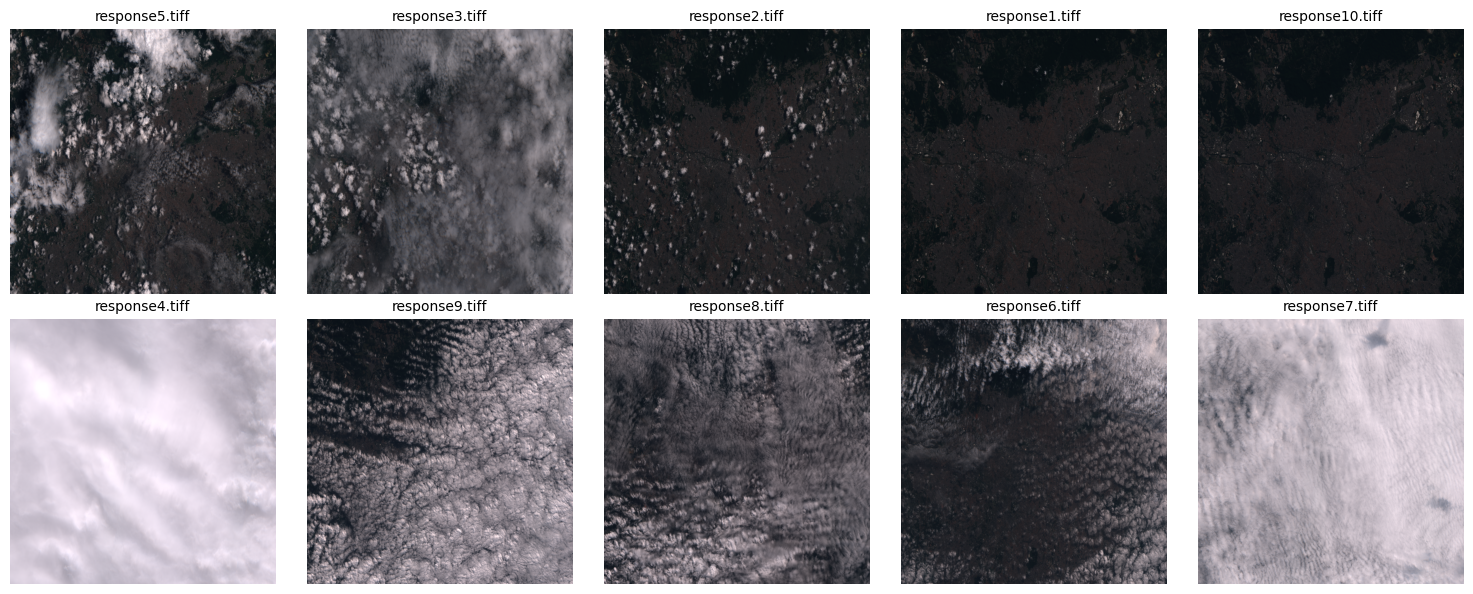

In [31]:
import rasterio
import matplotlib.pyplot as plt
import os
import numpy as np

# lista todos os arquivos TIFF no diretório especificado
image_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith('.tiff')]

# determina quantos subplots são necessários
n_images = len(image_files)
cols = 5  # número de colunas na grade de imagens
rows = (n_images + cols - 1) // cols  # calcular o número de linhas necessárias

fig, axs = plt.subplots(rows, cols, figsize=(15, 3 * rows))
axs = axs.ravel()

# função para ler e exibir uma imagem
def show_image(image_path, ax):
    with rasterio.open(image_path) as src:
        # supondo que a imagem é RGB, lemos as três primeiras bandas
        red, green, blue = src.read([1, 2, 3])

        # criando um array RGB para visualização
        img = np.stack((red, green, blue), axis=-1)

        # ajustar o contraste das imagens
        img = img / img.max()

        # mostrar a imagem
        ax.imshow(img)
        ax.set_title(os.path.basename(image_path), fontsize=10)
        ax.axis('off')

# exibir as imagens em subplots
for i, image_file in enumerate(image_files):
    show_image(image_file, axs[i])

for ax in axs[i+1:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

# 2 - Pipeline de processamento e preparação de dados de imagens e funções de testes que compara resultados esperados com os obtidos

In [34]:
# função para normalizar a imagem
def normalize_image(image):
    return image / np.max(image)

# função para converter a imagem
def convert_to_grayscale(image):
    return np.dot(image[..., :3], [0.2989, 0.5870, 0.1140])

# funções de teste
def test_normalize_image():
    test_img = np.array([[100, 200], [150, 250]], dtype=float)
    expected_output = np.array([[0.4, 0.8], [0.6, 1.0]])
    np.testing.assert_array_almost_equal(normalize_image(test_img), expected_output)

def test_convert_to_grayscale():
    test_img = np.array([[[123, 234, 32], [12, 90, 200]]], dtype=float)
    expected_output = np.array([[123*0.2989 + 234*0.5870 + 32*0.1140,
                                 12*0.2989 + 90*0.5870 + 200*0.1140]])
    np.testing.assert_array_almost_equal(convert_to_grayscale(test_img), expected_output, decimal=6)

# testes para verificar as funções
test_normalize_image()
test_convert_to_grayscale()

# 3 - Base de dados de imagens processadas em um dataframe

In [35]:
import pandas as pd

# lista todos os arquivos TIFF no diretório especificado
image_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith('.tiff')]

# cria DataFrame para armazenar os dados das imagens processadas
columns = ['filename', 'grayscale_image', 'normalized_image']
df_images = pd.DataFrame(columns=columns)

# processar e armazenar dados das imagens
for image_file in image_files:
    with rasterio.open(image_file) as src:
        img = np.stack([src.read(i) for i in range(1, 4)], axis=-1)

        # Aplica o processamento
        normalized_img = normalize_image(img)
        grayscale_img = convert_to_grayscale(img)

        # cria um novo DataFrame para a imagem atual
        new_row = pd.DataFrame({
            'filename': [os.path.basename(image_file)],
            'grayscale_image': [grayscale_img],
            'normalized_image': [normalized_img]
        })

        # concatena o novo DataFrame com o principal
        df_images = pd.concat([df_images, new_row], ignore_index=True)

# exibe o DataFrame
print(df_images.head())

          filename                                    grayscale_image  \
0   response5.tiff  [[29.9045, 28.214399999999998, 30.2034, 26.246...   
1   response3.tiff  [[62.318799999999996, 64.0197, 65.367799999999...   
2   response2.tiff  [[29.100299999999997, 20.546400000000002, 23.8...   
3   response1.tiff  [[25.6276, 19.144399999999997, 20.6065, 17.845...   
4  response10.tiff  [[25.029799999999998, 18.2477, 21.4215, 17.959...   

                                    normalized_image  
0  [[[0.09803921568627451, 0.12549019607843137, 0...  
1  [[[0.24313725490196078, 0.23921568627450981, 0...  
2  [[[0.10588235294117647, 0.11764705882352941, 0...  
3  [[[0.09411764705882353, 0.10196078431372549, 0...  
4  [[[0.08627450980392157, 0.10196078431372549, 0...  
